In [1]:
%load_ext autoreload
%autoreload 2

# Notebook: Scikit-learn Models

In [1]:
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set()

## Load the dataset

In [3]:
from ceruleo.dataset.catalog.CMAPSS import CMAPSSDataset

2022-08-11 12:21:57.614798: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/luciano/venvs/ceruleo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_dataset = CMAPSSDataset(train=True, models='FD001')

test_dataset = CMAPSSDataset(train=False, models='FD001')[15:30]

### Create a transformer for a dataset

In [5]:
from ceruleo.transformation.functional.transformers import Transformer
from ceruleo.transformation.features.selection import ByNameFeatureSelector
from ceruleo.transformation.functional.pipeline.pipeline import make_pipeline
from ceruleo.transformation.features.scalers import MinMaxScaler
from ceruleo.dataset.catalog.CMAPSS import sensor_indices
FEATURES = [train_dataset[0].columns[i] for i in sensor_indices]


In [6]:

transformer = Transformer(
    pipelineX=make_pipeline(
        ByNameFeatureSelector(features=FEATURES), 
        MinMaxScaler(range=(-1, 1))

    ), 
    pipelineY=make_pipeline(
        ByNameFeatureSelector(features=['RUL']),  
    )
)



## Split train-test-validation

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_dataset, val_dataset = train_test_split(train_dataset, train_size=0.9)

In [9]:
len(train_dataset), len(val_dataset), len(test_dataset)

(90, 10, 15)

# Models

## Scikit-learn

In [10]:
import sklearn.pipeline as sk_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from ceruleo.models.sklearn import EstimatorWrapper, TimeSeriesWindowTransformer, CeruleoRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler

In [11]:

regressor = CeruleoRegressor(
    TimeSeriesWindowTransformer(
        transformer,
        window_size=32,
        padding=True,
        step=1),   
    Ridge(alpha=15))

regressor.fit(train_dataset)

CeruleoRegressor(regressor=Ridge(alpha=15),
                 ts_window_transformer=TimeSeriesWindowTransformer(transformer=<ceruleo.transformation.functional.transformers.Transformer object at 0x7fc96e6b2410>,
                                                                   window_size=32))

### Val dataset results

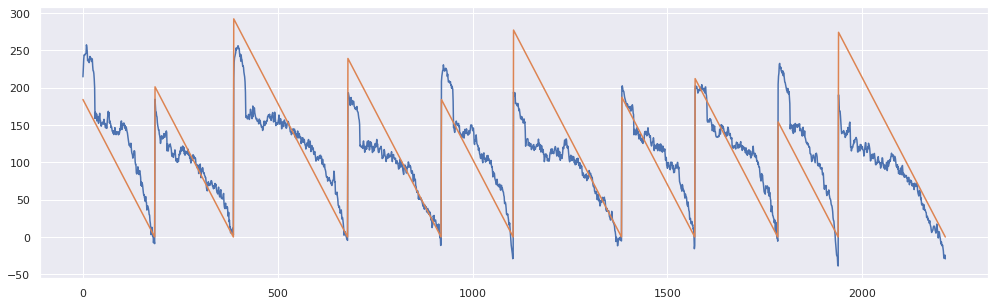

In [12]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(regressor.predict(val_dataset))
ax.plot(regressor.ts_window_transformer.true_values(val_dataset))

### Test dataset results

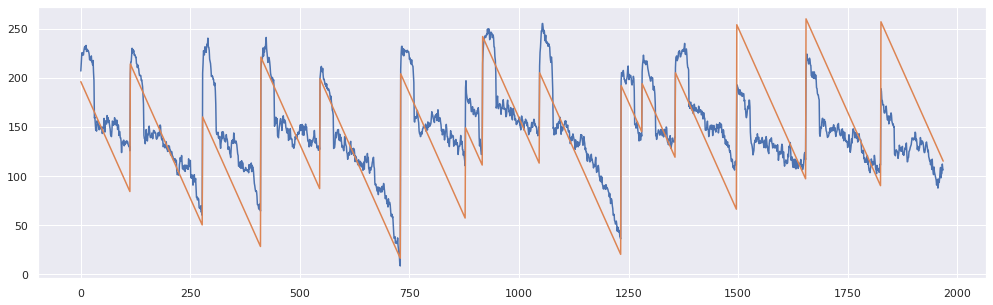

In [13]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(regressor.predict(test_dataset))
ax.plot(regressor.ts_window_transformer.true_values(test_dataset))

## Parameters grid search


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
from ceruleo.models.sklearn import CeruleoMetricWrapper

regressor_gs = CeruleoRegressor(
    TimeSeriesWindowTransformer(
        transformer,
        window_size=32,
        padding=True,
        step=1),   
    Ridge(alpha=15))

grid_search = GridSearchCV(
    estimator=regressor_gs,
     param_grid={
        'ts_window_transformer__window_size': [5, 10],         
        'regressor': [Ridge(alpha=15), RandomForestRegressor(max_depth=5)]
    },
    scoring=CeruleoMetricWrapper('neg_mean_absolute_error')
)


grid_search.fit(train_dataset)

GridSearchCV(estimator=CeruleoRegressor(regressor=Ridge(alpha=15),
                                        ts_window_transformer=TimeSeriesWindowTransformer(transformer=<ceruleo.transformation.functional.transformers.Transformer object at 0x7fc96e6b2410>,
                                                                                          window_size=32)),
             param_grid={'regressor': [Ridge(alpha=15),
                                       RandomForestRegressor(max_depth=5)],
                         'ts_window_transformer__window_size': [5, 10]},
             scoring=<ceruleo.models.sklearn.CeruleoMetricWrapper object at 0x7fc96cb80f40>)

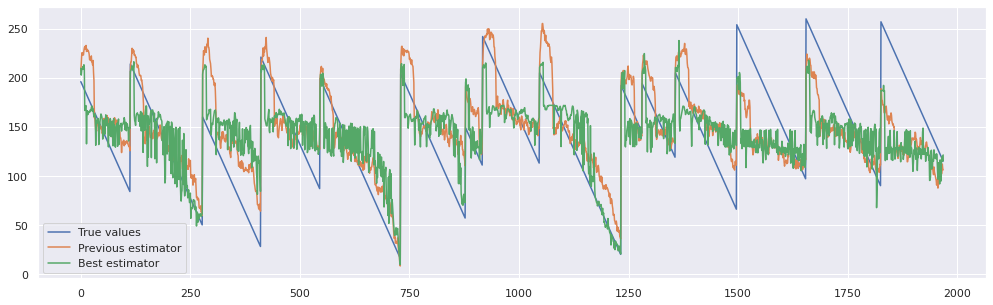

In [15]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(regressor.ts_window_transformer.true_values(test_dataset), label='True values')
ax.plot(regressor.predict(test_dataset), label='Previous estimator')

ax.plot(grid_search.best_estimator_.predict(test_dataset), label='Best estimator')
ax.legend()
